In [ ]:
"Here are the codes used for data analysis of gtfs data of bus lines. 
"You can find 3 sections." 
"- The fist one is the treatment needed to exploit the data ( reduction to one bus line, namae correction etc .. )"
"- Data to export to the right format" 
"- Unexploited codes (functionning)"

In [ ]:
Data treatment 

In [ ]:
#Import all libraries needed


import pandas as pd
#interactive whiteboard manager
import tkinter as tk 
from tkinter import filedialog 
from tkinter.filedialog import askopenfilename

root = tk.Tk()
root.withdraw
file_path =tk.filedialog.askopenfilename() 

       #Files Reader  
#df is the dfataframe meaning the table 

df=pd.read_csv(file_path,header=0,
                                   sep= ";",
                                   #quotechar=' " ',
                                   engine='python',)

root.destroy()
#Print the table imported 
print(df)

In [ ]:
#This is a funtion to export the final table named df 
#Warnin: you nead to change the name "df" everywhere if you are exporting a dataframe with another name. 
def export (df):
    export_file_path = filedialog.asksaveasfilename(defaultextension='.xlsx')
    df.to_excel(export_file_path,index = False, header=True,sheet_name="")
export(df)

In [ ]:
#Getting timetable of each line 

#Runtime errors sometimes slip into the reading of the code. In order to anticipate these problems, it is common to use
# functions that allow execution to continue despite the error, such as "Try"
try:
    for i in range (0,len(df)): 
        #Here we must change the line number corresponding to the name that interests us. 
        if df['id:2'][i]!=9:
            
            #Reminder, on each line of code and conditions, you must not put an indent like here.
            df = df.drop(i,axis=0)
                      
            #Here the variable df takes the known columns of the excel table by reducing them only to equivalent values
            #to the road we have chosen
            
except KeyError:
    pass  #    


df=df.reset_index()
#After the reset of index, you have a column named index wich is too much
df=df.drop(labels='index',axis=1)
#Sometimes you run the code more than once. In this case you can see a column name level_0 appear. The next line is t erase it. 
#df=df.drop(labels='level_0',axis=1)

df

In [ ]:
#REQUEST WITH GET 
#Calculation a first time of the altitude on the file retained only for the road which interests us


import requests
import pandas as pd

import csv
import tkinter as tk 
from tkinter import filedialog 
from tkinter.filedialog import askopenfilename
import time 

import requests
import json

#definitin of the the column altitute that we will be using 

df['altitude']=""


#the function used to make the altitude request     
def get_elevation(lat, long):
    #link of the website where we get the values from 
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query).json()  # json object, various ways you can extract value
    # one approach is to use pandas json functionality:
    #Elevation is a temporary variable used to stock the value obatined from request 
    elevation = pd.json_normalize(r, 'results')['elevation'].values[0]
    return elevation


for i in range(0,len(df)):

    df.loc[i,'altitude']= get_elevation(df['stop_lat'][i],df['stop_lon'][i])
    #Sometimes the code crash if there is too much request 
    #This is used to slow it
    time.sleep(1)
#You can prinf df here too to be sure of the value you are getting with print(df) 


In [ ]:
#Distances calculated using Open Stree Map on the same data set as previously 

#Import of the requieredlibrary for OSM 
import webbrowser
from pyroutelib3 import Router

#This is the library used to make a map with thepoints we want 
import folium



df['distance']=""




for i in range (0,len(df)):
    for j in range (0,len(df)):
        #if ((df['id:3'][i]==df['id:3'][j]) and (df['stop_name'][i]!=df['stop_name'][j]) and  (df['stop_sequence'][j]==df['stop_sequence'][i]+1) ): 
        
         if (df['id:3'].iloc[i]==df['id:3'].iloc[j]): 
                if (df['stop_name'].iloc[i]!=df['stop_name'].iloc[j]) :
                    if  (df['stop_sequence'].iloc[j]==df['stop_sequence'].iloc[i]+1) :
                        ##import des bibliothèques

                        ##choix du type de parcours et de l'icone
                        router = Router("bus")#on cherche à construire un parcours pour : car, cycle, foot, horse, tram, train
                        icone="bus"#choix de l'icone des marqueurs
                        ##on identifie les points de départ et d'arrivée
                        point_depart = (df['stop_lat'].iloc[i], df['stop_lon'].iloc[i])
                        point_arrivee = (df['stop_lat'].iloc[j], df['stop_lon'].iloc[j])
                        depart = router.findNode(point_depart[0], point_depart[1])
                        arrivee = router.findNode(point_arrivee[0], point_arrivee[1])
                        status, route = router.doRoute(depart, arrivee)
                        if status == 'success':
                            routeLatLons = list(map(router.nodeLatLon, route))
                        #routeLatLons est un tuple qui stocke les latitudes et les longitudes
                        #routeLatLons[0] est la liste des latitudes
                        #routeLatLons[1] est la liste des longitudes
                        ##initialisation de la carte et choix de l'échelle




                        ##calcul des distances cumulées
                        L=len(routeLatLons)#taille de la liste = nombre de points
                        d=[]#initialisation de la distance : liste vide
                        d_cum=[]#initialisation de la distance cumulée: liste vide
                        for k in range(1, L):
                            d.append(router.distance(routeLatLons[k-1],routeLatLons[k]))#liste des distances entre deux points
                            d_cum.append(sum(d))#liste des distances cumulées
    #distance=    max(d_cum)
                            distance=round(d_cum[-1], 2)#écriture arrondie à deux chiffres après la virgule
    df['distance'].iloc[i]=distance
    distance=0
df            
#export(df)





In [ ]:
#This part isn't necessary 
#It is used to print the road and all the nodes of OSM on a map 
#The map format is HTML 

#Localisation of the map with the coordonates of the road wanted
#You need to change point_depart, point_arrivee and routeLatLons carefully to print all the road you want 

c= folium.Map(location=[(point_depart[0]+point_arrivee[0])/2, (point_depart[1]+point_arrivee[1])/2],
zoom_start=13)
#We mark the start 
folium.Marker(routeLatLons[0], popup="Départ", icon=folium.Icon(icon=icone, prefix="fa",
color="green")).add_to(c) #we draw the road in a desired color
#on maak the arrival 
folium.Marker(routeLatLons[-1], popup="Arrivée après "+str(distance)+ " km", icon=folium.Icon(icon=icone,
prefix="fa", color="red")).add_to(c)
##we trace the road 
folium.PolyLine(routeLatLons, color="blue", weight=2.5, opacity=3).add_to(c)
##save of the map 
c.save('maRoute.html')


##we score some points
pas=1
for i in range(0, L-1, pas):#we position markers every ...not...points
    folium.Circle(routeLatLons[i], radius=1,color="red", popup="point n°"+str(i)+" : "+str(round(d_cum[i],2))+"km").add_to(c)
c.save('maRoute.html')    
webbrowser.open('maRoute.html')    
    

In [ ]:

#This section is used to get the maximum stops of a bus trip
#This means that for each bus trip number we have a value of maximum bus stops he it faces
#This value will helps us importants items like the list of all bus routes/paths 


#We import warning to use it in order to hide everywarning in this section. 
#Due to some implementations comming, python warrant us that some methodology may not work in the future
#As it sounds useful, it is more disturbing because a mesage display at each implementation 
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


#We create here a table containing all trips number by
trip_list= df['id:3'].drop_duplicates()
trip_list=trip_list.reset_index()
trip_list=trip_list.drop(labels='index',axis=1)
trip_list["statuts"]= 0
trip_list["max_seq"]=""

#Creation of the column of the maximum of bus stops 
df['max_seq']=""


for i in range (0,len(df)):
    #We want to get every stops in the right ordonancy in each travel 
    #Firstly we copy the dataframe of the correspondant bus line 
    stops_list=df
    for j in range (0,len(trip_list)):
    #Each time we get the correspondance of the trip number on both sides, original datafram and the table of bus trips numbers 
    #We then drop all other rows in other to keep the stops list of only the corresponded bus trip. 
        if (df['id:3'].iloc[i]== trip_list['id:3'][j]) and trip_list["statuts"][j]==0:
            
            try:
                for k in range (0,len(stops_list)): 
                    if stops_list['id:3'][k]!=trip_list['id:3'][j]:
                        stops_list = stops_list.drop(k,axis=0)
                        trip_list["statuts"][j]=1
                        
            except KeyError:
                pass  #    

            #As soon as we get all the bus stops and sequency the copy the value of the maximum one to past it in each iteration of df 
            
        
            df['max_seq'].iloc[i]=stops_list['stop_sequence'].max()
            trip_list["max_seq"][j]=stops_list['stop_sequence'].max()
            
        elif (df['id:3'].iloc[i]== trip_list['id:3'][j]) and trip_list["statuts"][j]==1:
            
            df['max_seq'].iloc[i]=trip_list["max_seq"][j]
#trip_list display

df

In [ ]:
#We want to find one the existing roads/paths of aLL the length of road existing 
#d is a structure that witll stock those roads 


import warnings
warnings.filterwarnings('ignore')

df['paths']=""
#d is a tructure full of tables corresponding to the first set of roads with the length of roads existing 
d = {}

#path_list
# is a dataframe we will use to get all the roads from the reduced roads list (d) 
#path_list isat this step only filled of the max_seq , meaning only the sizes of roads reduced (no duplicates) 
paths_list= df['max_seq'].drop_duplicates()
paths_list=paths_list.reset_index()
paths_list=paths_list.drop(labels='index',axis=1)
#creation of a column to number all the 
paths_list['paths']=""
#a is a varaible used to make sure that we are filling the exact number of reduced roads/paths 
a=0
#initialisation of j 
j=1

#numerotation of roads 
for i in range (0,len(paths_list['max_seq'])):
    paths_list['paths'].iloc[i]= i+1
        
                
for i in range(0,len(df)):
    if a<len(paths_list):
        if (df['max_seq'][i]==paths_list['max_seq'][a]):
            name=paths_list['max_seq'][a]
     
            d[name] = pd.DataFrame(columns=['stops'], index=range(df['max_seq'][i]))
            d[name].index = d[name].index + 1
            for j in range (1,df['max_seq'][i]+1):         
                ff= df.set_index(['id:3','stop_sequence'])
                d[name]['stops'][j]=ff.at[(df['id:3'][i], j), 'stop_name']
            d[name].index = d[name].index -1
            print(d[name])
            a=a+1
            

In [ ]:
#Filling of the lists corresponding to the routes with the names of the stops as well as the numbering of the list of the number of routes
#Medium_path_list is the array with all the arrays of the different routes
#to display it you have to write Medium_path_list[i], i being the number of the road and starting with 0
import warnings
warnings.filterwarnings('ignore')

#cpt, cpt1, cpt2 and cpt3 are all counters to make sure we are filling all the roads existing apart from the one listed inthe previous section 
k=1
cpt=1
aaa=1
Medium_path_list = {}
for i in range (1,len(paths_list['max_seq'])+1):
    Medium_path_list[i]= d[paths_list['max_seq'][i-1]]
   
    





df['paths']=""
for i in range(0,len(df)):
    
    for j in range (1, len (paths_list['max_seq'])+1):
      
        if j ==1 :
            aaa=1 
        if aaa!= 2: 
            cpt2=0
            cpt3=0
            if df['max_seq'][i] == len(Medium_path_list[j]): 
                for k in range (0,len(Medium_path_list[j])): 
                    
                    gg= df.set_index(['id:3','stop_sequence'])


                    aaa=2
                    if (gg.at[(df['id:3'][i], k+1), 'stop_name']!= Medium_path_list[j]['stops'][k]):
                        aaa=3
                                             
                        for l in range (j, len (paths_list['max_seq'])+1):
                            
                            
                            if df['max_seq'][i] == len(Medium_path_list[l]) and cpt3 != 1:
                                cpt=1
                                for m in range (0,len(Medium_path_list[l])): 

                                    if (gg.at[(df['id:3'][i], m+1), 'stop_name'] != Medium_path_list[l]['stops'][m]):
                                        cpt2=1
                                                                          
                                    elif (gg.at[(df['id:3'][i], m+1), 'stop_name']== Medium_path_list[l]['stops'][m]):
                                        cpt=cpt+1
            
                                    if cpt-1 == len(Medium_path_list[j]) :
                                        cpt2=0
                                        cpt3=1
                                        l=len (paths_list['max_seq'])+1
                                     

                        if cpt-1 != len(Medium_path_list[j]) and cpt2!=0 and df['max_seq'][i] == len(Medium_path_list[j]): 
                   


                            ef = ef.append({'max_seq':df['max_seq'][i], 'paths':len(paths_list['max_seq'])+1  }, ignore_index=True)
                            Medium_path_list[len(paths_list['max_seq'])] = pd.DataFrame(columns=['stops'], index=range(len(Medium_path_list[j])))
                            Medium_path_list[len(paths_list['max_seq'])].index = Medium_path_list[len(paths_list['max_seq'])].index + 1
                            for n in range (1,df['max_seq'][i]+1):
                                hh= df.set_index(['id:3','stop_sequence'])
                                Medium_path_list[len(paths_list['max_seq'])]['stops'][n]=hh.at[(df['id:3'][i], n), 'stop_name']
                              
                            Medium_path_list[len(paths_list['max_seq'])].index = Medium_path_list[len(paths_list['max_seq'])].index -1
                             
                            break
    
                    

In [ ]:
#Attribution of road numbers to the gtfs table and therefore to each iteration of trips that we have in the table
#gg here is to set a function to look for id:3, the trip number and the sequency value 
gg= df.set_index(['id:3','stop_sequence'])
for i in range (0,len(df)):
    
    for j in range (0,len(paths_list)):
        cpt=0
        if df['max_seq'][i] == paths_list['max_seq'][j]:
            for k in range (0,len(Medium_path_list[j+1])):
                #it is the same principle as before, after equality found from two loops we ass the value (here obtained with gg) to the initial dataframe (of our bus line) 
                if Medium_path_list[j+1]['stops'][k]==gg.at[(df['id:3'][i], k+1), 'stop_name']:
                    cpt=cpt+1
            if cpt== len (Medium_path_list[j+1]): 
                #we fill path number
                df['paths'].iloc[i]=paths_list['paths'][j]
                

In [ ]:
#indicators/ parameters in the gtfs table ( 1line bus data)
import warnings
warnings.filterwarnings('ignore')
#datetim is the adequate lib to use for time manipulation in dataframe 

from datetime import datetime
#FMT is for time format 
FMT = '%H:%M:%S.%f'
#This is the time format used in the GTFS data 

df['time_to_pass']= ""
df['speed_to']= ""
df['diff_alt']= ""

for i in range (0,len(df)):
    for j in range (0,len(df)):
        if (df['id:3'][i]==df['id:3'][j]) and (df['stop_sequence'][i]+1==df['stop_sequence'][j]) :
            #Conversion before time difference 
            df['time_to_pass'][i]=(datetime.strptime(df['arrival_time'][j],FMT)-datetime.strptime(df['departure_time'][i],FMT)).seconds

            if df['distance'][i]!=0 : 
    
                df['speed_to'][i]=  3600*df['distance'][i]/(df['time_to_pass'][i])
                df['diff_alt'][i]= df['altitude'][j]-df['altitude'][i]
            else :
                #The speed is 0 if the distance is 0
                df['speed_to'][i]= 0
                
            
    

In [ ]:
#timetables of the different routes
#paths/roads tables filled with of new columns 

for i in range (0,len(paths_list)):
    Medium_path_list[i+1]['stop_id']=""
    Medium_path_list[i+1]['route_short_name']=""
    Medium_path_list[i+1]['stop_lat']=""
    Medium_path_list[i+1]['stop_lon']=""
    
    Medium_path_list[i+1]['stop_sequence']=""
    
    Medium_path_list[i+1]['distance']=""
    Medium_path_list[i+1]['time_to_pass']=""
    Medium_path_list[i+1]['speed_to']=""
    Medium_path_list[i+1]['altitude']=""
    Medium_path_list[i+1]['diff_alt']=""
    Medium_path_list[i+1]['max_seq']=""
    Medium_path_list[i+1]['distance_debut']=""
    Medium_path_list[i+1]['path_id']=""
    
    
   
    
   
    
    
    
hh= df.set_index(['id:3','stop_sequence'])  

for i in range (0,len(paths_list)):
    for j in range(0,len(Medium_path_list[i+1]['stops'])):
        for k in range  (0,len(df)):
            if df['paths'][k]==i+1 and df['stop_name'][k]==Medium_path_list[i+1]['stops'][j]:
                Medium_path_list[i+1]['stop_id'][j]=df['stop_id'][k]
                Medium_path_list[i+1]['route_short_name'][j]=df['route_short_name'][k]
                Medium_path_list[i+1]['stop_lat'][j]=df['stop_lat'][k]
                Medium_path_list[i+1]['stop_lon'][j]=df['stop_lon'][k]
    
                Medium_path_list[i+1]['stop_sequence'][j]=df['stop_sequence'][k]
    
                Medium_path_list[i+1]['distance'][j]=df['distance'][k]
                Medium_path_list[i+1]['time_to_pass'][j]=df['time_to_pass'][k]
                Medium_path_list[i+1]['speed_to'][j]=df['speed_to'][k]
                Medium_path_list[i+1]['altitude'][j]=df['altitude'][k]
                Medium_path_list[i+1]['diff_alt'][j]=df['diff_alt'][k]
                Medium_path_list[i+1]['max_seq'][j]=df['max_seq'][k]
                Medium_path_list[i+1]['path_id'][j]= i+1
                
for i in range (0,len(paths_list)):
    for j in range(0,len(Medium_path_list[i+1]['stops'])): 
               if j ==0:
                    Medium_path_list[i+1]['distance_debut'][j]=0
                    
                elif j!=0 and j!= len(Medium_path_list[i+1]['stops']):
                    
                    Medium_path_list[i+1]['distance_debut'][j]=  Medium_path_list[i+1]['distance_debut'][j-1]+Medium_path_list[i+1]['distance'][j-1]

               
            
        

                              
    

In [ ]:
#bus_schedule 

In [ ]:
#flotte_de_bus

In [ ]:
#services (of the table such as schools bus ) and not the service  of the bus during the day 

sf= df['service_id'].drop_duplicates()
sf=sf.reset_index()
sf=sf.drop(labels='index',axis=1)
print(sf)
    

In [ ]:
#voyages/trips 

vf= df['trip_id'].drop_duplicates()
vf=vf.reset_index()
vf=vf.drop(labels='index',axis=1)
#vf = vf.rename({'id:3': 'trips_id'}, axis='columns')
print(vf)

In [ ]:
#trajets 
pf= df['paths'].drop_duplicates()
pf=pf.reset_index()
pf=pf.drop(labels='index',axis=1)
pf = pf.rename({'paths': 'path_id'}, axis='columns')
print(pf)

In [ ]:
#arrêts

arr= df['stop_id'].drop_duplicates()
arr=arr.reset_index()
arr=arr.drop(labels='index',axis=1)
arr['stop_lat']=""
arr['stop_lon']=""

#arr = arr.rename({'paths': 'paths_id'}, axis='columns')
#ff= df.set_index(['id:3','stop_sequence'])
#d[name]['stops'][j]=ff.at[(df['id:3'][i], j), 'stop_name']

for i in range (0,len(arr['stop_id'])):
    for j in range (0,len(df)):
        if arr['stop_id'][i]==df['stop_id'][j]:
            arr['stop_lat'][i]=df['stop_lat'][j]
            arr['stop_lon'][i]=df['stop_lon'][j]
print(arr)

In [ ]:
#service_matrcie 

mf= df['trip_id'].drop_duplicates()
mf=mf.reset_index()
mf=mf.drop(labels='index',axis=1)
mf['service_id']=""



for i in range (0,len(arr['trip_id'])):
    for j in range (0,len(df)):
        if mf['trip_id'][i]==df['trip_id'][j]:
            mf['service_id'][i]=df['stop_lat'][j]
            arr['stop_lon'][i]=df['stop_lon'][j]

print(mf)
    

In [ ]:
#voyage_matrice

vm= df['stop_name'].drop_duplicates()
vm=vm.reset_index()
vm=vm.drop(labels='index',axis=1)
#vf = vf.rename({'id:3': 'trips_id'}, axis='columns')
vm['arrival_time']=""
vm['departure_time']=""

for i in range (0,len(vm['stop_name'])):
    for j in range (0,len(df)):
        if vm['trip_id'][i]==df['trip_id'][j]:
            vm['arrival_time'][i]=df['arrival_time'][j]
            vm['departure_time'][i]=df['departure_time'][j]

print(vm)

In [ ]:
## Import an excel file xlxs si on décie travailler avec un fichier enregistré précédemment en xlxs


import requests
import pandas as pd
import win32com.client as win32
import csv
import tkinter as tk 
from tkinter import filedialog 
from tkinter.filedialog import askopenfilename
import time 
root = tk.Tk()
root.withdraw
file_path =tk.filedialog.askopenfilename() 
root.destroy()

       #Lecture fichier 
df=pd.read_excel(file_path)
#print(df)

In [ ]:
#We use OSM lib to make resquest and get intermadiates points to find the existing bus road 
#We use the command POST to make request to open elevation to get the altitude of all the points found 

import webbrowser
from pyroutelib3 import Router
import folium
import requests
import pandas as pd
import csv
import tkinter as tk 
from tkinter import filedialog 
from tkinter.filedialog import askopenfilename
import time 
import requests
import json

#Initialisation of variables 
Last_point = 0  #Index of the last nodes to add 
long = 0 #total legth of the path with all nodes 
temp = 0 #temporary nodes list
#Creation of a structure of bus routes with intermediates points called Long_path_list
Long_path_list = {}


for j in range (1,len(Medium_path_list)+1): 
    #Creation of a long enough table to stock all the intermediate points of a road. We chosed an arbitrary value of index = 100 000 
    #It can be implemeted if it's not sufficent enough 
    #Creation of new columns in the created dataframe where we will have all the paths and intermediates points (noeuds), their coordinates, 
    #altitudes, cumulatives distance from the beginning and stop names
    Long_path_list [j] =  pd.DataFrame(columns=['Noeuds'], index= range(100000))
    Long_path_list [j] ['Lat'] = ""
    Long_path_list [j] ['Lon'] = ""
    Long_path_list[j]['Altitude'] = ""
    Long_path_list[j]['Distance'] = ""
    Long_path_list[j]['Arrets'] = "" 
    
    
    
#Function to get the altitudes of each points (bus stops) through coordinates Latitude and Longitude     
def altitude (lat, lon):


    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query).json()  # json object, various ways you can extract value
    # one approach is to use pandas json functionality:
    elevation = pd.json_normalize(r, 'results')['elevation'].values[0]
    time.sleep(0.25) 
    return elevation

for k in range (1,len(Medium_path_list)+1):
    print(k) 
    print(len(Medium_path_list))
    for i in range (0,len(Medium_path_list[k])):
        for j in range (0,len(Medium_path_list[k])):
            if (Medium_path_list[k]['stop_sequence'][i]+1==Medium_path_list[k]['stop_sequence'][j]): 

                ##import of libs

                ##choice of route type and icon
                router = Router("bus")#we are looking to build a route for: car, cycle, football, horse, tram, train
                icone="bus"#choice of marker icon
                ##we identify the starting and ending points
                point_depart = (Medium_path_list[k]['stop_lat'].iloc[i], Medium_path_list[k]['stop_lon'].iloc[i])
                point_arrivee = (Medium_path_list[k]['stop_lat'].iloc[j], Medium_path_list[k]['stop_lon'].iloc[j])
                depart = router.findNode(point_depart[0], point_depart[1])
                arrivee = router.findNode(point_arrivee[0], point_arrivee[1])
                status, route = router.doRoute(depart, arrivee)
                if status == 'success':
                    routeLatLons = list(map(router.nodeLatLon, route))
                #routeLatLons est un tuple qui stocke les latitudes et les longitudes
                #routeLatLons[0] est la liste des latitudes
                #routeLatLons[1] est la liste des longitudes
            
                L=len(routeLatLons)#taille de la liste = nombre de points
                d=[]#initialisation de la distance : liste vide
                d_cum=[]#initialisation de la distance cumulée: liste vide
                for m in range(1, L):
                    d.append(router.distance(routeLatLons[m-1],routeLatLons[m]))#liste des distances entre deux points
                    d_cum.append(sum(d))#liste des distances cumulées

        #distance=    max(d_cum)

                    distance=round(d_cum[-1], 2)#write rounded to two decimal places
                    if i== 0 and m == 1    : 
                        Long_path_list[k]['Distance'].iloc[0] = 0
                        Long_path_list[k]['Altitude'].iloc[0] = altitude(point_depart[0],point_depart[1])
                        Long_path_list[k]['Lat'].iloc[0]= point_depart[0]
                        Long_path_list[k]['Lon'].iloc[0]= point_depart[1]
                        Long_path_list[k]['Arrets'].iloc[0]= i+1
                        long=0
                        temp=router.distance(point_depart,routeLatLons[0])
                    elif i!= 0 and m == 1 :
                        long = long + LL 
                    Long_path_list[k]['Distance'].iloc[m+long]= temp + router.distance(routeLatLons[m-1],routeLatLons[m])
                    Long_path_list[k]['Altitude'].iloc[m+long]= altitude(routeLatLons[m][0],routeLatLons[m][1])
                    Long_path_list[k]['Lat'].iloc[m+long]= routeLatLons[m][0]
                    Long_path_list[k]['Lon'].iloc[m+long]= routeLatLons[m][1]
                    Long_path_list[k]['Arrets'].iloc[m+long]= i+1
                    temp = temp +  router.distance(routeLatLons[m-1],routeLatLons[m])
                Long_path_list[k]['Distance'].iloc[m+long+1]= temp + router.distance(routeLatLons[L-1],point_arrivee)
                Long_path_list[k]['Altitude'].iloc[m+long+1]= altitude(point_arrivee[0],point_arrivee[1])
                Long_path_list[k]['Lat'].iloc[m+long+1]= point_arrivee[0]
                Long_path_list[k]['Lon'].iloc[m+long+1]= point_arrivee[1]
                Long_path_list[k]['Arrets'].iloc[m+long+1]= i+2
                
                #variabls used to help positionning the bus stop at the right index after each intermediates nodes 
                LL =  L
                Last_point = routeLatLons[L-1] 

        distance=0


In [ ]:
#Creation of a new dataframe called time_list to list all the time combination an d variation of a bus line 

from datetime import datetime 
# a and c are counters 
a=0
c=0
#creation of the struc time_list for 
time_list = {}
FMT = '%H:%M:%S.%f'

for i in range (0,len(ef['paths'])):
    time_list[i+1] = pd.DataFrame(columns=['t_stop'], index=range(ef['max_seq'][i]))
    time_list[i+1].index = time_list[i+1].index + 1
    

for i in range (0,len(ef['paths'])):
    a=0
    for j in range (0,len(df)):
        if df['paths'][j]==i+1 and a==0:
            time_list[i+1][c+1]=""
            c=c+1
            for l in range(0,len(dd[i+1]['stops'])-1):
                ff= df.set_index(['id:3','stop_sequence'])                              
                time_list[i+1][c][l+1]= (datetime.strptime(ff.at[(df['id:3'][j], l+2), 'arrival_time'] ,FMT)-datetime.strptime(ff.at[(df['id:3'][j], l+1), 'departure_time'],FMT)).seconds

    time_list[i+1]=time_list[i+1].drop(labels='t_stop',axis=1)
    time_list[i+1]= time_list[i+1].T.drop_duplicates().T
    

for i in range (0,len(ef['paths'])):
    for j in range (0,len(time_list[i+1].columns)):
        time_list[i+1].columns.values[j] = j+1
        
#you can print time_list to see        

In [ ]:

# Assign  data of buus trips you wan to be part of your services.  
data = {'id_trip': [622, 631, 625, 640]}  
  
# Creation of DataFrame to callect all the trips  
bf = pd.DataFrame(data) #bf of dataframe of bus trip  
#counters 
e=0
f=0
b=0
a=0
for i in range (0,len(bf)): 
    d=0
    for j in range (0, len(df)): 
        if df['id:3'][j]== bf['id_trip'][i] and d==0:
            a=a+df['max_seq'][j]
            d=1
            
gf =  pd.DataFrame(columns=['stop_name'], index=range(a))
#gf is the dataframe to list all the stops of the of the trips combined 
try:
    gf['stop_id']=""
    gf['route_short_name']=""
    gf['stop_lat']=""
    gf['stop_lon']=""
    gf['stop_sequence']=""
    gf['distance']=""
    gf['time_to_pass']=""
    gf['speed_to']=""
    gf['altitude']=""
    gf['diff_alt']=""
    gf['max_seq']=""
    
except KeyError:
    pass  #    


for i in range (0,len(bf)): 
    e=0
    for j in range (0,len(df)): 
        if df['id:3'][j]== bf['id_trip'][i] and e==0:
            b=b+df['max_seq'][j] 
            f= f+df['max_seq'][j]
            if i==0:
                d=0
            for l in range (d,f):
                gf['stop_name'][l]=dd[df['paths'][j]]['stops'][l-d]
                gf['stop_id'][l]=dd[df['paths'][j]]['stop_id'][l-d]
                gf['route_short_name'][l]=dd[df['paths'][j]]['route_short_name'][l-d]
                gf['stop_lat'][l]=dd[df['paths'][j]]['stop_lat'][l-d]
                gf['stop_lon'][l]=dd[df['paths'][j]]['stop_lon'][l-d]
                gf['stop_sequence'][l]=dd[df['paths'][j]]['stop_sequence'][l-d]
                gf['distance'][l]=dd[df['paths'][j]]['distance'][l-d]
                gf['time_to_pass']=""
                gf['speed_to']=""
                gf['altitude'][l]=dd[df['paths'][j]]['altitude'][l-d]
                gf['diff_alt'][l]=dd[df['paths'][j]]['diff_alt'][l-d]
                gf['max_seq'][l]=dd[df['paths'][j]]['max_seq'][l-d]
                if l==f-1:
                    d=f  
            e=1
#You can print gf if you want to see the bus service of the line that you defined          

Text(0.5, 1.0, "Routes de l'oise")

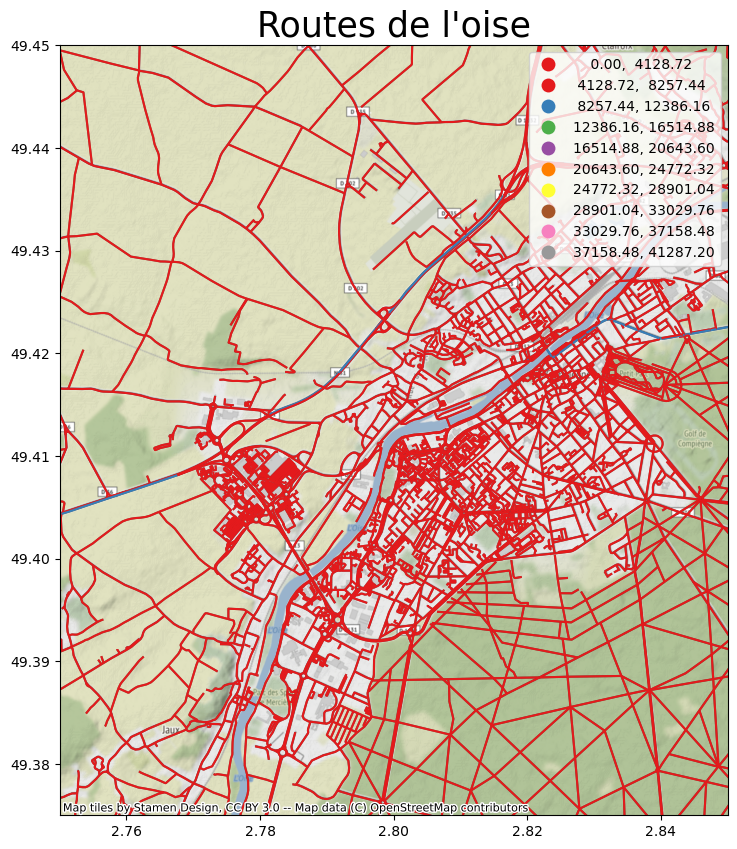

In [6]:
#Display traffic volume of oise/France and a focus on compiègne city 

#import of library 
import pandas as pd
import tkinter as tk 
from tkinter import filedialog 
from tkinter.filedialog import askopenfilename
import matplotlib.pyplot as plt
#lib of the environement of the ap 
import contextily as cx
import geopandas as gpd

#load the shapefile (shp or bdf for file processing) 
root = tk.Tk()
root.withdraw
file_path =tk.filedialog.askopenfilename() 
root.destroy() 

#shp reader 
shapefile = gpd.read_file(file_path)

#Zoom on compiègne  
ax = shapefile.plot(figsize=(10,10), alpha=0.5, edgecolor='k')
ax.set_xlim(2.75,2.85)
ax.set_ylim(49.375,49.450)
#add an environement to the map (background) 
cx.add_basemap(ax, crs=shapefile.crs)

#Map ploting with parameters (colors, scheme distribution, 
shapefile.plot (ax=ax, column = "trafficvol",vmin= 1,vmax =10, cmap ="Set1", categorical="True",legend = "True",scheme="equal_interval",k=10,figsize=(15, 10), missing_kwds={
        "color": "red",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
    },)

#Text and frame adjustment 
ax.axis("on")
ax.set_title("Routes de l'oise", fontdict ={ 'fontsize': "25", 'fontweight': "5"})


